# inputting data to an LSTM

The goal of this document is to show how to reshape our input to match the expections of an LSTM. 

In [65]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import tensorflow.keras as keras
import helpers
import time


In [29]:
helpers.check_gpu_tensorflow()

is CUDA available: True
Tensorflow version  2.6.0
Keras version  2.6.0


In [54]:
sequence_length = 3 # this sequence has a length of 3 so it has 3 timesteps
num_sequences = 3000
test_num = 500

In [50]:
data = [ [i+j for j in range(sequence_length)] for i in range(num_sequences) ]
data = np.array(data)
print("training_data: \n", data)

offset = 1
target = [ [i+j+1 for j in range(sequence_length)] for i in range(offset, num_sequences+offset)]
target = np.array(target)
print("\ntarget_data: \n", target)

training_data: 
 [[   0    1    2]
 [   1    2    3]
 [   2    3    4]
 ...
 [2997 2998 2999]
 [2998 2999 3000]
 [2999 3000 3001]]

target_data: 
 [[   2    3    4]
 [   3    4    5]
 [   4    5    6]
 ...
 [2999 3000 3001]
 [3000 3001 3002]
 [3001 3002 3003]]


In [51]:
### Normalizing the data so we have our max and min in range of 0 to 1

# np.argmax will find the index of the biggest number of a flattened array, and we use that
# to divdide all the elements to get a range between 1 and 0
max_in_training = data.flatten()[np.argmax(data)] # gets max val in data
max_in_labels = target.flatten()[np.argmax(target)] # gets max val in target

normalization_factor = max_in_training

if(max_in_labels > normalization_factor):
    normalization_factor = max_in_labels

data = data/normalization_factor
target = target/normalization_factor

print("After normalization \n")
print("training_data: \n", data)
print("\ntarget_data: \n", target)

After normalization 

training_data: 
 [[0.00000000e+00 3.33000333e-04 6.66000666e-04]
 [3.33000333e-04 6.66000666e-04 9.99000999e-04]
 [6.66000666e-04 9.99000999e-04 1.33200133e-03]
 ...
 [9.98001998e-01 9.98334998e-01 9.98667999e-01]
 [9.98334998e-01 9.98667999e-01 9.99000999e-01]
 [9.98667999e-01 9.99000999e-01 9.99333999e-01]]

target_data: 
 [[6.66000666e-04 9.99000999e-04 1.33200133e-03]
 [9.99000999e-04 1.33200133e-03 1.66500167e-03]
 [1.33200133e-03 1.66500167e-03 1.99800200e-03]
 ...
 [9.98667999e-01 9.99000999e-01 9.99333999e-01]
 [9.99000999e-01 9.99333999e-01 9.99667000e-01]
 [9.99333999e-01 9.99667000e-01 1.00000000e+00]]


In [52]:
print(data.shape)

(3000, 3)


# We see from above that we have 1000 sequences each sequence has 3 timesteps
Our Sequences are 1 row, and 3 columns per sequence, in otherwords our sequences are matrices of shape (1,3) so that is the shape we have to feed our LSTM
LSTM expects that we feed it shape (batch_size, timesteps, features), but that is confusing, so I think of it this way, an LSTM expects (batch_size, rows_per_sequence, columns_per_sequence)

We need to reflect the rows_per_sequence in our data shape somehow, we do this by chaging the
data shape from (1000,3) to be like this (1000, 1, 3), on otherwords we are injecting the rows_per_sequence into our data shape, it is an empty axis that is just like wrapping the data with an extra list like if the data is like this [a,b,c] we are making it like this [[a,b,c]] 

In [53]:
# following the discussion above, we reshape our data to be  like this
current_shape = data.shape
new_shape = current_shape[0], 1, current_shape[1]
data = data.reshape(new_shape)
target = target.reshape(new_shape)
data.shape

(3000, 1, 3)

In [64]:
# splitting test_ds from data and target sets
# using negative test_num means that I access the last test_num element index, 
# in other words indexing the list from the back
test_input_ds = data[-test_num:]
test_label_ds = target[-test_num:]

data = data[:-test_num]
target = target[:-test_num]

In [58]:
model = Sequential()
# each seq is 1 row and 3 columns
model.add(LSTM(sequence_length, name= "input_lstm", input_shape=(1, 3), return_sequences=True, recurrent_dropout=0.2, activation='sigmoid'))
model.add(LSTM(sequence_length, input_shape=(1, 3), return_sequences=True, recurrent_dropout=0.2, activation='sigmoid'))
model.add(LSTM(sequence_length, input_shape=(1, 3), return_sequences=True, recurrent_dropout=0.2, activation='sigmoid'))
model.add(LSTM(sequence_length, input_shape=(1, 3), return_sequences=True, recurrent_dropout=0.2, activation='sigmoid'))
model.add(LSTM(sequence_length, input_shape=(1, 3), return_sequences=True, recurrent_dropout=0.2, activation='sigmoid'))
model.add(LSTM(sequence_length, input_shape=(1, 3), return_sequences=True, recurrent_dropout=0.2, activation='sigmoid'))

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_lstm (LSTM)            (None, 1, 3)              84        
_________________________________________________________________
lstm_16 (LSTM)               (None, 1, 3)              84        
_________________________________________________________________
lstm_17 (LSTM)               (None, 1, 3)              84        
_________________________________________________________________
lstm_18 (LSTM)               (None, 1, 3)              84        
_________________________________________________________________
lstm_19 (LSTM)               (None, 1, 3)              84        
_________________________________________________________________
lstm_20 (LSTM)               (None, 1, 3)              84        
Total params: 504
Trainable params: 504
Non-trainable params: 0
________________________________________________________

In [66]:

EARLYSTOP = keras.callbacks.EarlyStopping(
                monitor="accuracy", mode="auto", restore_best_weights=True, patience=25)

start_time = time.time()
history = model.fit(data, target, epochs=10000, batch_size=32, verbose=0,validation_split=0.2, callbacks=EARLYSTOP)
print("--- %s seconds ---" % (time.time() - start_time))

--- 21.016963958740234 seconds ---


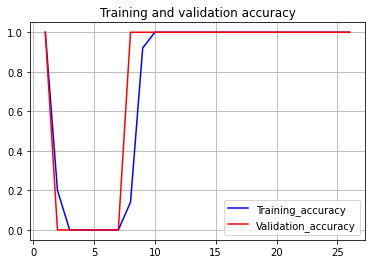

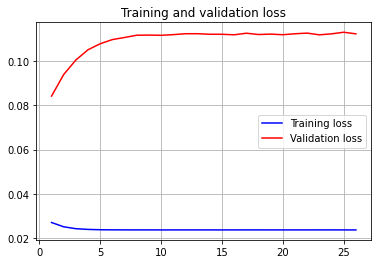

In [67]:
helpers.plot_training_validation_accuracy_loss(history)


In [79]:
predict = model.predict(data)
predict*normalization_factor
# target*normalization_factor

array([[[940.10364, 935.18823, 940.51044]],

       [[940.10364, 935.18823, 940.51044]],

       [[940.10364, 935.18823, 940.51044]],

       ...,

       [[940.10345, 935.1887 , 940.5105 ]],

       [[940.10345, 935.1887 , 940.5105 ]],

       [[940.10345, 935.1887 , 940.5105 ]]], dtype=float32)

In [72]:
# Evaluate the model
loss, acc = model.evaluate(test_input_ds, test_label_ds, verbose=2)
print("model accuracy: {:5.2f}%".format(100 * acc))

16/16 - 0s - loss: 0.1937 - accuracy: 1.0000
model accuracy: 100.00%


### we see that the model prediction is pretty bad lol it is not following the pattern in the data and instead has leanred to give constant values. But that is fine since the whole goal of this exeresie was to configure LSTM by using reshape.
If we want to use a dense layer after an LSTM that has return_sequences=true we should wrap that dense with a TimeDistributed which will duplicate the dense layer enough times so that matches the seq length